# Primal and Dual SGD for the Support Vector Machine Problem

In this notebook we compare the performance of primal and dual SVM on a toy problem. We use our own implementations of SGD because this lets us save the history of the training process, which we then use to examine the progress in learning curves.

Our goal here is not to find a particularly nice or efficient implementation. When we compare the runtime of both methods in a different part of the project, we use the Scikit-learn implementation instead. For simplicity we also forgo fitting an intercept term.

## 1. The Problem

We work with the the Support Vector Machine (SVM) problem in the following formulation:

#### Primal:

\begin{equation}\label{eq:primal}
  \min_{w \in R^d} \  \sum_{i=1}^n \ell(y_i X_i^\top w) + \frac 1 2|w\|^2
\end{equation}
where $\ell : R\rightarrow R$, $\ell(z) := \max\{0,1-z\}$ is the hinge loss function.
Here for any $i$, $1\le i\le n$, the vector $x_i\in R^d$ is the $i$-th data example, and $y_i\in\{\pm1\}$ is the corresponding label.

(see equations 9 and 20 in the report)

#### Dual:

\begin{equation}\label{eq:dual}
 \max_{\boldsymbol{\alpha} \in R^n } \  \alpha^\top\boldsymbol{1} - \tfrac1{2} \alpha^\top Y X X^\top Y\alpha
 \text{    such that    $0\le \alpha_i \le 1  \ \forall i$}
\end{equation}
where $Y := \mathop{diag}(y)$, and $X\in R^{n \times d}$ again collects all $n$ data examples as its columns.

(matrix notation of equation 16a)

## 2. The Problem Instance

We load an SVM dataset on which we will test both methods.

In [6]:
from collections import defaultdict
import numpy as np
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_svmlight_file
import random
%matplotlib inline

# we have uploaded this dataset
DATA_TRAIN_PATH = 'svmguide1.txt'
DATA_Test_PATH = 'svmguide1_test.txt'

x_train, y_train = load_svmlight_file(DATA_TRAIN_PATH)
x_train = x_train.toarray()
# labels should only be 1 or -1
y_train = np.array(([1 if i==1 else -1 for i in y_train]))

x_test, y_test = load_svmlight_file(DATA_Test_PATH)
x_test = x_test.toarray()
y_test = np.array([1 if i==1 else -1 for i in y_test])

# scale the problem
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3089, 4) (3089,)
(4000, 4) (4000,)


We quickly try the sklearn implementation to have a sanity check for our own implementation:

In [2]:
from sklearn.svm import LinearSVC

clf_primal = LinearSVC(dual=False, verbose=10, fit_intercept=False)
clf_primal.fit(x_train, y_train)
clf_primal.score(x_test, y_test)

[LibLinear]

0.882

In [3]:
clf_dual = LinearSVC(dual=True, verbose=10, fit_intercept=False)
clf_dual.fit(x_train, y_train)
clf_dual.score(x_test, y_test)

[LibLinear]

0.88175

## 3. Our Implementation

This section can be skipped if you are not interested in the technical details of the implementation.

Our code is based on what we have done in the exercises. We implement stochastic gradient descent for the primal and dual objective in a way that also returns a history of intermediate results.

In [7]:
def calculate_accuracy(y, A, w):
    """
    Compute the training accuracy on the training set (can be called for test set as well).
    y: +1 or -1 labels, shape = (num_examples)
    A: Dataset matrix, shape = (num_examples, num_features)
    w: Model weights, shape = (num_features)
    return: scalar value
    """
    pred = A @ w
    for i in range(len(pred)):
        if pred[i] > 0:
            pred[i] = 1
        else:
            pred[i] = -1 
    return np.mean(pred == y)

### 3.1 SGD for the Primal Objective

In [5]:
def calculate_primal_objective(y, A, w):
    reg = (1/2) * np.linalg.norm(w)**2
    loss = 0
    for i in range(len(y)):
        loss += max(0, 1 - y[i] * A[i].T @ w)
    return loss + reg

In [6]:
def compute_stoch_gradient_svm(x, y, w, n):
    grad = 0
    pred = w @ x
    
    if 1 - y*pred <= 0:
        grad = w
    else:
        grad = w - n*y*x
    return grad

In [7]:
def stochastic_gradient_descent_primal(X, y, gamma, batch_size=1, max_iter=200000, trace=False):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(X)
    w_t = np.zeros(num_features)
    
    
    current_iter = 0
    while (current_iter < max_iter):
        i = random.randint(0,num_data_points - 1)
        y_i, x_i = y[i], X[i]
        gradient = compute_stoch_gradient_svm(x_i, y_i, w_t, num_data_points)
        w_t = w_t - gamma * gradient
        if current_iter % 100000 == 0:
            primal_value = calculate_primal_objective(y, X, w_t)
            print('iteration=%i, primal:%.5f'%(
                    current_iter, primal_value))
        if current_iter % 100 == 0:
            primal_value = calculate_primal_objective(y, X, w_t)
            if trace:
                history['acc'].append(calculate_accuracy(y,X,w_t))
                history['objective_function'].append(primal_value)
                history['iter'].append(current_iter)
        current_iter += 1
    return w_t, history

### 3.2 SGD for the Dual Objective

In [3]:
def calculate_dual_objective(y, A, alpha):
    Y = np.diag(y)
    return sum(alpha) - (1/2) * alpha.T @ Y @ A @ A.T @ Y @ alpha

In [4]:
def calculate_dual_stoch_gradient(x, y, i, alpha):
    return 1 - y[i] * np.sum( np.diag(alpha*y) @ x @ x[i].T )

In [5]:
def stochastic_gradient_descent_dual(X, y, gamma, batch_size=1, max_iter=200000, trace=False):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(X)
    alpha = np.zeros(num_data_points)
    
    
    current_iter = 0
    while (current_iter < max_iter):
        i = random.randint(0,num_data_points - 1)
        gradient_i = calculate_dual_stoch_gradient(X, y, i, alpha)
        alpha[i]= alpha[i] + gamma * gradient_i
        if alpha[i] > 1: alpha[i] = 1
        if alpha[i] < 0: alpha[i] = 0
        if current_iter % 1000 == 0:
            dual_value = calculate_dual_objective(y, X, alpha)
            print('iteration=%i, dual:%.5f'%(
                    current_iter, dual_value))
        if current_iter % 100 == 0:
            dual_value = calculate_dual_objective(y, X, alpha)
            if trace:
                history['acc'].append(calculate_accuracy(y, X, X.T @ np.diag(y) @ alpha))
                history['objective_function'].append(dual_value)
                history['iter'].append(current_iter)
        current_iter += 1
    return alpha, history

## 4. Execution

### 4.1 Primal SVM

Let us try out the primal method on our datset:

In [11]:
w, hist = stochastic_gradient_descent_primal(x_train, y_train, gamma=0.000001, max_iter=400000)

iteration=0, primal:3086.55938
iteration=100000, primal:922.56387
iteration=200000, primal:858.70635
iteration=300000, primal:844.37605


In [12]:
calculate_accuracy(y_train, x_train, w)
calculate_accuracy(y_test, x_test, w)

0.883

(Notice that these results are similar to the performance of the sklearn classifier.)

In [13]:
# try different learning rates
res = []
lr = [0.000001, 0.00001, 0.000005, 0.0000005]
for i in lr:
    w, hist = stochastic_gradient_descent_primal(x_train, y_train, gamma=i, max_iter=600000, trace=True)
    print(i)
    print(calculate_accuracy(y_train, x_train, w))
    res.append(hist)

iteration=0, primal:3090.07525
iteration=100000, primal:923.98944
iteration=200000, primal:858.71333
iteration=300000, primal:844.47143
iteration=400000, primal:840.32599
iteration=500000, primal:837.09805
1e-06
0.900615085788281
iteration=0, primal:3059.50031
iteration=100000, primal:839.55527
iteration=200000, primal:836.37472
iteration=300000, primal:835.39056
iteration=400000, primal:835.44980
iteration=500000, primal:835.57974
1e-05
0.8986727096147621
iteration=0, primal:3075.16746
iteration=100000, primal:836.87461
iteration=200000, primal:839.90632
iteration=300000, primal:837.60580
iteration=400000, primal:835.16347
iteration=500000, primal:835.05417
5e-06
0.9028811913240531
iteration=0, primal:3089.81143
iteration=100000, primal:1042.65160
iteration=200000, primal:925.69310
iteration=300000, primal:879.38628
iteration=400000, primal:859.11669
iteration=500000, primal:850.20702
5e-07
0.9035286500485594


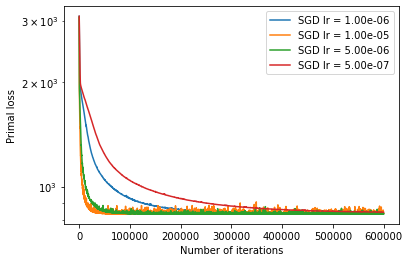

In [14]:
# plot learning curves in terms of primal loss
lr = [0.000001, 0.00001,0.000005,0.0000005]
for i in range(len(res)):
    r = res[i]
    plt.plot(r["iter"], r["objective_function"], label="SGD lr = "+"{:.2e}".format(lr[i]))
    plt.yscale('log')
    plt.ylabel('Primal loss')
    plt.xlabel('Number of iterations')

plt.legend()

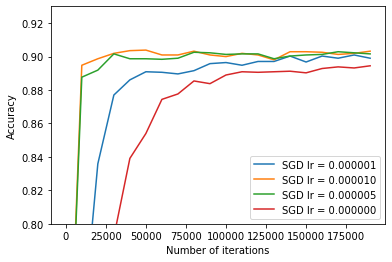

In [15]:
# plot learning curves in terms of accuracy
for i in range(len(res)):
    r = res[i]
    plt.plot(r["iter"][:2000:100], r["acc"][:2000:100], label="SGD lr = {:1.6f}".format(lr[i]))
    plt.ylim(0.8, 0.93)
    plt.ylabel('Accuracy')
    plt.xlabel('Number of iterations')
    
plt.legend()

### 4.2 Dual SVM

Next we test the dual method on the same dataset:

In [16]:
alpha, hist = stochastic_gradient_descent_dual(x_train, y_train, gamma=0.1, batch_size=1, max_iter=5000, trace=True)

iteration=0, dual:0.09770
iteration=1000, dual:50.05919
iteration=2000, dual:86.25459
iteration=3000, dual:118.94832
iteration=4000, dual:149.95761


In [17]:
# recover the solution to the primal problem
w = x_train.T @ np.diag(y_train) @ alpha

print(calculate_accuracy(y_train, x_train, w))
print(calculate_accuracy(y_test, x_test, w))

0.8889608287471674
0.8885


(Note that the final results are similar to the sklearn classifier, and also to the primal method.)

In [8]:
# try multiple learning rates
res2 = []
lr2 = [0.9,0.5,0.05,0.1]
for i in lr2:
    alpha, hist = stochastic_gradient_descent_dual(x_train, y_train, gamma=i, batch_size=1, max_iter=200000, trace=True)
    print(i)
    res2.append(hist)

iteration=0, dual:0.19133
iteration=1000, dual:236.21317
iteration=2000, dual:355.92855
iteration=3000, dual:461.01352
iteration=4000, dual:531.15610
iteration=5000, dual:595.69142
iteration=6000, dual:648.38978
iteration=7000, dual:684.47406
iteration=8000, dual:719.74868
iteration=9000, dual:740.46784
iteration=10000, dual:762.10513
iteration=11000, dual:774.84371
iteration=12000, dual:785.33599
iteration=13000, dual:794.06975
iteration=14000, dual:800.38271
iteration=15000, dual:806.17052
iteration=16000, dual:812.68375
iteration=17000, dual:817.34868
iteration=18000, dual:820.48397
iteration=19000, dual:822.93237
iteration=20000, dual:824.04701
iteration=21000, dual:824.89946
iteration=22000, dual:826.33922
iteration=23000, dual:827.45418
iteration=24000, dual:828.23673
iteration=25000, dual:829.05326
iteration=26000, dual:829.73624
iteration=27000, dual:830.22090
iteration=28000, dual:830.63986
iteration=29000, dual:831.39299
iteration=30000, dual:831.68266
iteration=31000, dual:8

iteration=54000, dual:833.36077
iteration=55000, dual:833.43490
iteration=56000, dual:833.50171
iteration=57000, dual:833.55967
iteration=58000, dual:833.69424
iteration=59000, dual:833.76553
iteration=60000, dual:833.82461
iteration=61000, dual:833.86436
iteration=62000, dual:833.89263
iteration=63000, dual:833.93311
iteration=64000, dual:833.95580
iteration=65000, dual:833.99541
iteration=66000, dual:834.02074
iteration=67000, dual:834.03922
iteration=68000, dual:834.05362
iteration=69000, dual:834.06915
iteration=70000, dual:834.09200
iteration=71000, dual:834.11185
iteration=72000, dual:834.13105
iteration=73000, dual:834.14259
iteration=74000, dual:834.15392
iteration=75000, dual:834.16704
iteration=76000, dual:834.17742
iteration=77000, dual:834.20029
iteration=78000, dual:834.21068
iteration=79000, dual:834.22175
iteration=80000, dual:834.24378
iteration=81000, dual:834.25194
iteration=82000, dual:834.26381
iteration=83000, dual:834.28228
iteration=84000, dual:834.29596
iteratio

iteration=108000, dual:811.18589
iteration=109000, dual:811.66634
iteration=110000, dual:812.21672
iteration=111000, dual:812.65581
iteration=112000, dual:813.17974
iteration=113000, dual:813.67111
iteration=114000, dual:814.24498
iteration=115000, dual:814.68806
iteration=116000, dual:815.07510
iteration=117000, dual:815.52018
iteration=118000, dual:815.89818
iteration=119000, dual:816.27450
iteration=120000, dual:816.76387
iteration=121000, dual:817.05800
iteration=122000, dual:817.44595
iteration=123000, dual:817.77422
iteration=124000, dual:818.14602
iteration=125000, dual:818.52727
iteration=126000, dual:818.87307
iteration=127000, dual:819.19939
iteration=128000, dual:819.53684
iteration=129000, dual:819.84970
iteration=130000, dual:820.15942
iteration=131000, dual:820.41512
iteration=132000, dual:820.70860
iteration=133000, dual:820.97954
iteration=134000, dual:821.24148
iteration=135000, dual:821.50873
iteration=136000, dual:821.71454
iteration=137000, dual:821.94621
iteration=

iteration=160000, dual:833.12599
iteration=161000, dual:833.14917
iteration=162000, dual:833.16826
iteration=163000, dual:833.19211
iteration=164000, dual:833.21836
iteration=165000, dual:833.24194
iteration=166000, dual:833.26350
iteration=167000, dual:833.28853
iteration=168000, dual:833.30503
iteration=169000, dual:833.32875
iteration=170000, dual:833.34510
iteration=171000, dual:833.36230
iteration=172000, dual:833.38553
iteration=173000, dual:833.40513
iteration=174000, dual:833.42325
iteration=175000, dual:833.44488
iteration=176000, dual:833.46115
iteration=177000, dual:833.47923
iteration=178000, dual:833.49763
iteration=179000, dual:833.51866
iteration=180000, dual:833.54205
iteration=181000, dual:833.55375
iteration=182000, dual:833.56753
iteration=183000, dual:833.58492
iteration=184000, dual:833.59577
iteration=185000, dual:833.61377
iteration=186000, dual:833.63229
iteration=187000, dual:833.64689
iteration=188000, dual:833.66624
iteration=189000, dual:833.68294
iteration=

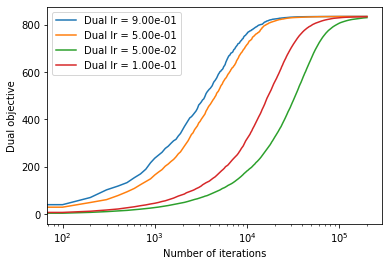

In [9]:
# plot learning curves in terms of dual objective
for i in range(len(res2)):
    r = res2[i]
    plt.plot(r['iter'], r['objective_function'],label="Dual lr = "+"{:.2e}".format(lr2[i]))
    plt.xscale('log')
    plt.ylabel('Dual objective')
    plt.xlabel('Number of iterations')
plt.legend()

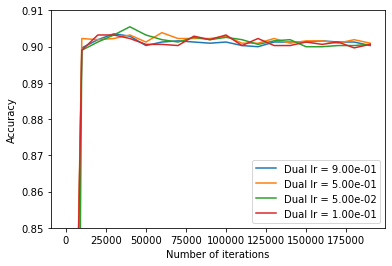

In [10]:
# plot learning curves in terms of accuracy
for i in range(len(res2)):
    r = res2[i]
    plt.plot(r["iter"][0::100], r["acc"][0::100], label="Dual lr = "+"{:.2e}".format(lr2[i]))
    plt.ylim(0.85, 0.91)
    plt.ylabel('Accuracy')
    plt.xlabel('Number of iterations')
plt.legend()
plt.show()